In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

In [2]:
# Causality param
eps = 5

device = torch.device('cpu')

# Define the exact solution
def exact_solution(x, t):
    return torch.sin(x)*torch.exp(t)

def initial_condition(x):
    return torch.sin(x)

def initial_condition_t(x):
    return torch.sin(x)

In [3]:
# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = 8*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init = torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition(init[:,0]).reshape(-1, 1).to(device)
u_init_t = initial_condition(init[:,0]).reshape(-1, 1).to(device)

xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = 0*torch.sin(tb_left).to(device)

xb_right = 8*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = 0*torch.sin(2*pi - tb_right).to(device)

x_int = torch.linspace(0, 8*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero

training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), u_init.to(device), u_init_t.to(device), b_left.to(device),  b_right.to(device), u_b_l.to(device), u_b_r.to(device)), batch_size=500, shuffle=False)

class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model


In [4]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=200)

In [5]:
my_network = my_network.to(device)

In [6]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

#Random Seed for weight initialization
retrain = 128
#Xavier weight initialization
init_xavier(my_network, retrain)


In [7]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")



In [8]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, u_initial, u_initial_t, bd_left, bd_right, ubl, ubr) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                u_initial_pred_ = model(initial)
                inputs = torch.ones(initial_pts, 1).to(device)
                grad_u_init = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inputs, create_graph=True)[0]
                u_init_t = grad_u_init[:, 1].reshape(-1, )

                # for left boundary
                bd_left.requires_grad = True
                bd_left_pred_ = model(bd_left)
                inputs = torch.ones(left_boundary_pts, 1).to(device)
                grad_bd_left = torch.autograd.grad(bd_left_pred_, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_left = grad_bd_left[:, 0].reshape(-1, )
                inputs = torch.ones(left_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_left = torch.autograd.grad(u_bd_x_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_left = grad_u_bd_x_left[:, 0].reshape(-1, )
                #inputs = torch.ones(left_boundary_pts, 1).reshape(-1, )
                #grad_u_bd_xx_left = torch.autograd.grad(u_bd_xx_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                #u_bd_xxx_left = grad_u_bd_xx_left[:, 0].reshape(-1, )

                # for right boundary
                bd_right.requires_grad = True
                bd_right_pred_ = model(bd_right)
                inputs = torch.ones(right_boundary_pts, 1).to(device)
                grad_bd_right = torch.autograd.grad(bd_right_pred_, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_right = grad_bd_right[:, 0].reshape(-1, )
                inputs = torch.ones(right_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_right = torch.autograd.grad(u_bd_x_right, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_right = grad_u_bd_x_right[:, 0].reshape(-1, )

                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xx = grad_u_x[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xx = torch.autograd.grad(u_xx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxx = grad_u_xx[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xxx = torch.autograd.grad(u_xxx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxxx = grad_u_xxx[:, 0].reshape(-1, )

                u_t = grad_u_hat[:, 1]
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_t = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]
                u_tt = grad_u_t[:, 1].reshape(-1, )

                pde_single_column = (u_tt.reshape(-1, ) + u_xxxx.reshape(-1, ) + \
                                     u_hat.reshape(-1, ) - 3*torch.sin(interior[:,0])*torch.exp(interior[:,1])) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                # Item 1. below

                loss_ic = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )) ** p) + \
                          torch.mean((u_init_t.reshape(-1, ) - u_initial_t.reshape(-1, )) ** p)
                #loss_pde = torch.mean((u_tt.reshape(-1, ) + u_xxxx.reshape(-1, )) ** p)
                loss_left_b = torch.mean((bd_left_pred_.reshape(-1, )) ** p) + \
                              torch.mean((u_bd_xx_left.reshape(-1, )) ** p)
                loss_right_b = torch.mean((bd_right_pred_.reshape(-1, )) ** p) + \
                               torch.mean((u_bd_xx_right.reshape(-1, )) ** p)

                loss = loss_ic + loss_pde + loss_left_b + loss_right_b

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

################################  0  ################################


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:234: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(


Loss:  8.751121520996094
################################  1  ################################
Loss:  8.618303298950195
################################  2  ################################
Loss:  7.4750165939331055
################################  3  ################################
Loss:  6.423558235168457
################################  4  ################################
Loss:  5.482895851135254
################################  5  ################################
Loss:  4.664233684539795
################################  6  ################################
Loss:  3.974196195602417
################################  7  ################################
Loss:  3.4111297130584717
################################  8  ################################
Loss:  2.9632351398468018
################################  9  ################################
Loss:  2.611626386642456
################################  10  ################################
Loss:  2.3357994556427
#######################

Loss:  0.8747795224189758
################################  86  ################################
Loss:  0.873541533946991
################################  87  ################################
Loss:  0.8723590970039368
################################  88  ################################
Loss:  0.8712151646614075
################################  89  ################################
Loss:  0.8700937032699585
################################  90  ################################
Loss:  0.8689545392990112
################################  91  ################################
Loss:  0.8677745461463928
################################  92  ################################
Loss:  0.8665366172790527
################################  93  ################################
Loss:  0.8651963472366333
################################  94  ################################
Loss:  0.8638060092926025
################################  95  ################################
Loss:  0.8623843193054199
#####

Loss:  0.7260497808456421
################################  170  ################################
Loss:  0.7246224284172058
################################  171  ################################
Loss:  0.7231859564781189
################################  172  ################################
Loss:  0.7217715382575989
################################  173  ################################
Loss:  0.7203823328018188
################################  174  ################################
Loss:  0.7190186381340027
################################  175  ################################
Loss:  0.7176938056945801
################################  176  ################################
Loss:  0.716380774974823
################################  177  ################################
Loss:  0.7150932550430298
################################  178  ################################
Loss:  0.7137637138366699
################################  179  ################################
Loss:  0.712447822093

Loss:  0.6474281549453735
################################  254  ################################
Loss:  0.6466734409332275
################################  255  ################################
Loss:  0.6459864377975464
################################  256  ################################
Loss:  0.645290195941925
################################  257  ################################
Loss:  0.6446070671081543
################################  258  ################################
Loss:  0.6439067125320435
################################  259  ################################
Loss:  0.6432169675827026
################################  260  ################################
Loss:  0.6424968242645264
################################  261  ################################
Loss:  0.6417753100395203
################################  262  ################################
Loss:  0.6410265564918518
################################  263  ################################
Loss:  0.640243589878

Loss:  0.5721383094787598
################################  338  ################################
Loss:  0.571026623249054
################################  339  ################################
Loss:  0.5699163675308228
################################  340  ################################
Loss:  0.5688371062278748
################################  341  ################################
Loss:  0.5677533745765686
################################  342  ################################
Loss:  0.5666999816894531
################################  343  ################################
Loss:  0.5656560063362122
################################  344  ################################
Loss:  0.5646504163742065
################################  345  ################################
Loss:  0.5636540651321411
################################  346  ################################
Loss:  0.5626670718193054
################################  347  ################################
Loss:  0.561680614948

Loss:  0.4574488401412964
################################  422  ################################
Loss:  0.455238401889801
################################  423  ################################
Loss:  0.45257091522216797
################################  424  ################################
Loss:  0.4501207768917084
################################  425  ################################
Loss:  0.4477769434452057
################################  426  ################################
Loss:  0.445264607667923
################################  427  ################################
Loss:  0.4432796835899353
################################  428  ################################
Loss:  0.4414843022823334
################################  429  ################################
Loss:  0.43973591923713684
################################  430  ################################
Loss:  0.43796125054359436
################################  431  ################################
Loss:  0.4363891482

Loss:  0.2424105703830719
################################  506  ################################
Loss:  0.23964370787143707
################################  507  ################################
Loss:  0.23713958263397217
################################  508  ################################
Loss:  0.2351345717906952
################################  509  ################################
Loss:  0.23300045728683472
################################  510  ################################
Loss:  0.23096022009849548
################################  511  ################################
Loss:  0.22896717488765717
################################  512  ################################
Loss:  0.2270369529724121
################################  513  ################################
Loss:  0.22512240707874298
################################  514  ################################
Loss:  0.22325079143047333
################################  515  ################################
Loss:  0.2213

Loss:  0.1461249589920044
################################  590  ################################
Loss:  0.14539456367492676
################################  591  ################################
Loss:  0.14466950297355652
################################  592  ################################
Loss:  0.14393751323223114
################################  593  ################################
Loss:  0.14320938289165497
################################  594  ################################
Loss:  0.14245294034481049
################################  595  ################################
Loss:  0.14170660078525543
################################  596  ################################
Loss:  0.14090557396411896
################################  597  ################################
Loss:  0.1401420384645462
################################  598  ################################
Loss:  0.13934610784053802
################################  599  ################################
Loss:  0.138

Loss:  0.06907618045806885
################################  673  ################################
Loss:  0.06817871332168579
################################  674  ################################
Loss:  0.0672643855214119
################################  675  ################################
Loss:  0.06631487607955933
################################  676  ################################
Loss:  0.06534890085458755
################################  677  ################################
Loss:  0.06439963728189468
################################  678  ################################
Loss:  0.06338037550449371
################################  679  ################################
Loss:  0.062452852725982666
################################  680  ################################
Loss:  0.06151333451271057
################################  681  ################################
Loss:  0.06060618534684181
################################  682  ################################
Loss:  0.0

Loss:  0.014383954927325249
################################  756  ################################
Loss:  0.014098145067691803
################################  757  ################################
Loss:  0.013815343379974365
################################  758  ################################
Loss:  0.01354129333049059
################################  759  ################################
Loss:  0.013282811269164085
################################  760  ################################
Loss:  0.013027334585785866
################################  761  ################################
Loss:  0.012797149829566479
################################  762  ################################
Loss:  0.012581441551446915
################################  763  ################################
Loss:  0.012386376969516277
################################  764  ################################
Loss:  0.01220285426825285
################################  765  ################################
Lo

Loss:  0.006227754522114992
################################  838  ################################
Loss:  0.0061981212347745895
################################  839  ################################
Loss:  0.006169428583234549
################################  840  ################################
Loss:  0.0061421687714755535
################################  841  ################################
Loss:  0.006115856114774942
################################  842  ################################
Loss:  0.006093278527259827
################################  843  ################################
Loss:  0.006071870680898428
################################  844  ################################
Loss:  0.006052527576684952
################################  845  ################################
Loss:  0.006033518351614475
################################  846  ################################
Loss:  0.006015143822878599
################################  847  ###############################

Loss:  0.004662174265831709
################################  920  ################################
Loss:  0.0046401177532970905
################################  921  ################################
Loss:  0.004615612793713808
################################  922  ################################
Loss:  0.004593631252646446
################################  923  ################################
Loss:  0.004572486970573664
################################  924  ################################
Loss:  0.004548300057649612
################################  925  ################################
Loss:  0.004526653327047825
################################  926  ################################
Loss:  0.004504039417952299
################################  927  ################################
Loss:  0.004484508186578751
################################  928  ################################
Loss:  0.004465464502573013
################################  929  ################################

Loss:  0.0040176864713430405
################################  1002  ################################
Loss:  0.004012671764940023
################################  1003  ################################
Loss:  0.004006470553576946
################################  1004  ################################
Loss:  0.004001828376203775
################################  1005  ################################
Loss:  0.003996199928224087
################################  1006  ################################
Loss:  0.0039932928048074245
################################  1007  ################################
Loss:  0.003988889046013355
################################  1008  ################################
Loss:  0.003987529315054417
################################  1009  ################################
Loss:  0.003984637558460236
################################  1010  ################################
Loss:  0.0039849597960710526
################################  1011  ####################

Loss:  0.00377318961545825
################################  1083  ################################
Loss:  0.0037640526425093412
################################  1084  ################################
Loss:  0.0037546283565461636
################################  1085  ################################
Loss:  0.0037417628336697817
################################  1086  ################################
Loss:  0.0037300928961485624
################################  1087  ################################
Loss:  0.0037158560007810593
################################  1088  ################################
Loss:  0.0037030200473964214
################################  1089  ################################
Loss:  0.0036890185438096523
################################  1090  ################################
Loss:  0.003675087820738554
################################  1091  ################################
Loss:  0.0036613948177546263
################################  1092  ################

Loss:  0.0034918934106826782
################################  1164  ################################
Loss:  0.0034868803340941668
################################  1165  ################################
Loss:  0.0034802770242094994
################################  1166  ################################
Loss:  0.0034742136485874653
################################  1167  ################################
Loss:  0.003467337228357792
################################  1168  ################################
Loss:  0.0034609974827617407
################################  1169  ################################
Loss:  0.0034557885956019163
################################  1170  ################################
Loss:  0.0034491191618144512
################################  1171  ################################
Loss:  0.00344365113414824
################################  1172  ################################
Loss:  0.003436984959989786
################################  1173  #################

Loss:  0.0031817806884646416
################################  1245  ################################
Loss:  0.0031767371110618114
################################  1246  ################################
Loss:  0.003177567617967725
################################  1247  ################################
Loss:  0.003176939906552434
################################  1248  ################################
Loss:  0.003178176237270236
################################  1249  ################################
Loss:  0.003179358085617423
################################  1250  ################################
Loss:  0.0031815986149013042
################################  1251  ################################
Loss:  0.0031838547438383102
################################  1252  ################################
Loss:  0.0031867879442870617
################################  1253  ################################
Loss:  0.003190365619957447
################################  1254  ##################

Loss:  0.003018794348463416
################################  1326  ################################
Loss:  0.0030184409115463495
################################  1327  ################################
Loss:  0.0030187787488102913
################################  1328  ################################
Loss:  0.003018866293132305
################################  1329  ################################
Loss:  0.0030185237992554903
################################  1330  ################################
Loss:  0.0030188618693500757
################################  1331  ################################
Loss:  0.0030188681557774544
################################  1332  ################################
Loss:  0.0030216530431061983
################################  1333  ################################
Loss:  0.0030223673675209284
################################  1334  ################################
Loss:  0.0030235350131988525
################################  1335  ###############

Loss:  0.0029696172568947077
################################  1407  ################################
Loss:  0.002967310603708029
################################  1408  ################################
Loss:  0.002964079612866044
################################  1409  ################################
Loss:  0.0029615836683660746
################################  1410  ################################
Loss:  0.0029585217125713825
################################  1411  ################################
Loss:  0.0029554092325270176
################################  1412  ################################
Loss:  0.0029529002495110035
################################  1413  ################################
Loss:  0.0029499810189008713
################################  1414  ################################
Loss:  0.0029476557392627
################################  1415  ################################
Loss:  0.0029450329020619392
################################  1416  ##################

Loss:  0.00288493768312037
################################  1488  ################################
Loss:  0.0028816473204642534
################################  1489  ################################
Loss:  0.002878999337553978
################################  1490  ################################
Loss:  0.0028763713780790567
################################  1491  ################################
Loss:  0.0028737098909914494
################################  1492  ################################
Loss:  0.0028717215172946453
################################  1493  ################################
Loss:  0.0028688698075711727
################################  1494  ################################
Loss:  0.0028675433713942766
################################  1495  ################################
Loss:  0.002865196904167533
################################  1496  ################################
Loss:  0.0028647775761783123
################################  1497  #################

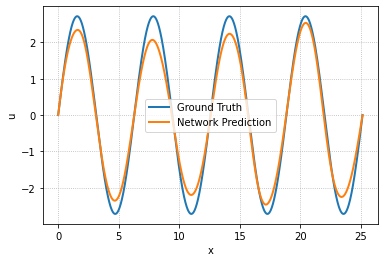

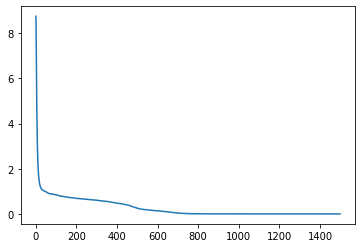

In [9]:
# n_epochs = 10000
start_time = time.time()
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
end_time = time.time()
total_time = end_time - start_time

print("Training time: {:.2f} seconds".format(total_time))

with open('p_ic_wo_c1.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p_ic_wo_c1.pth')

x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()

plt.plot(history)
plt.show()



Relative Error Test:  2.525847405195236 %


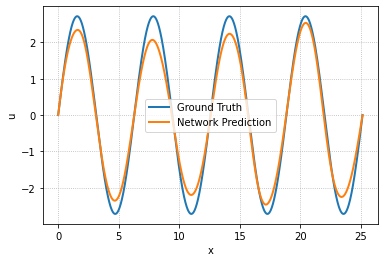

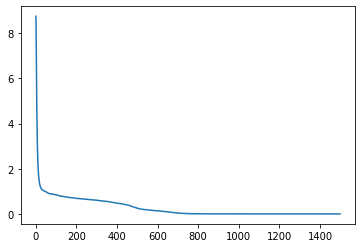

In [10]:
x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()

plt.plot(history)
plt.show()